<h3>Check energy conservation in the code<span class="tocSkip"></span></h3>
<div class="toc"><ul class="toc-item"></ul></div>

In [41]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn.apionly as sns
from matplotlib import animation, rc
from IPython.display import HTML
import sys
#sys.path.append('//n/home03/apop/XRay_Project/Compute_XRay/Xray_and_SZ/IllustrisScripts')
sys.path.append('./../behalf')
sys.path.append('./../')
#import behalf
#import octree
#import utils
import os
from glob import glob
%matplotlib inline
sns.set_context('poster')
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.labelsize'] = 20
# mpl.rcParams['ylabel.fontsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

In [2]:
def compute_energy(pos, vel, mass=None, G=4.483e-3):
    """
    Returns the total energy of the system defined by
    input positions (pos), velocities (vel), and masses (defaults
    to 1.0 for all particles), using units defined by choice of G.

    Total energy is the sum of potential and kinetic energy
    (see: compute_potential_energy and compute_kinetic_energy)

    Input:
       pos - positions (N x d)
       vel - velocities (N x d)
       mass - masses (optonal. Default: np.ones(N))
       G - Newton's Constant (optional. Default=1.)

    Output:
       E - total energy (float)
    """
    return compute_potential_energy(pos, mass=mass, G=G) +\
        compute_kinetic_energy(vel, mass=mass)


def compute_potential_energy(pos, mass=None, G=4.483e-3):
    """
    Returns the gravitational potential energy of the system defined by input
    positions (pos) and masses (defaults to 1.0 for all particles),
    using units defined by choice of G.
    
    Potential energy is defined as:
    U = - sum_i ( sum_[j > i] ( G * mass[i] * mass[j] / r_ij))
    r_ij = || pos[i] - pos[j] ||

    Input:
       pos - positions (N x d)
       mass - masses (optonal. Default: np.ones(N))
       G - Newton's Constant (optional. Default=1.)

    Output:
       U - Gravitational potential energy (float)
    """
    pos = np.array(pos).astype(float)
    N_part = pos.shape[0]
    if mass is None:
        mass = np.ones(N_part)
    elif type(mass) is float:
        mass = np.ones(N_part) * mass
    else:
        mass = np.array(mass).astype(float)
    assert mass.shape == (N_part,), ("input masses must match length of "
                                     "input positions")
    U = 0.
    for i in range(N_part):
        m_i = mass[i]
        m_j = mass[i+1:]
        dr = np.linalg.norm(pos[i] - pos[i+1:], axis=1)
        U -= np.sum(G * m_i * m_j / dr)
    return U


def compute_kinetic_energy(vel, mass=None):
    """
    Returns the kinetic of the system defined by input
    velocities and mass (defaults to 1.0 for all particles).
    
    Kinetic energy is defined as:
    K = 1/2 sum_i (mass[i] * ||vel[i]||**2)

    Input:
       vel - velocities (N x 3)
       mass - masses (optonal. Default: np.ones(N))

    Output:
       K - kinetic energy (float)
    """
    vel = np.array(vel).astype(float)
    N_part = vel.shape[0]
    if mass is None:
        mass = np.ones(N_part)
    elif type(mass) is float:
        mass = np.ones(N_part) * mass
    else:
        mass = np.array(mass).astype(float)
    N_part = vel.shape[0]
    assert mass.shape == (N_part,), ("input masses must match length of "
                                     "input velocities")
    return np.sum(vel.T**2. * mass) * 0.5

In [3]:
all_runs = [indir.split('/')[-1] for indir in glob('../results/*')]
all_runs

['baseline_test',
 'gpu_12-12_1000_100_100',
 'gpu_16-8_100000_3_100',
 'gpu_16-8_10000_10_100',
 'gpu_16-8_10000_10_100_prod',
 'gpu_16-8_1000_100_100',
 'gpu_16_1000_100_100',
 'gpu_1_1000_100_100',
 'gpu_1_16000_10_100',
 'gpu_1_4000_30_100',
 'gpu_2-2_1000_100_100',
 'gpu_24-12_100000_3_100',
 'gpu_24-12_10000_10_100',
 'gpu_24-12_1000_100_100',
 'gpu_2_1000_100_100',
 'gpu_32_1000_100_100',
 'gpu_384-8_10000_10_100',
 'gpu_384-8_1000_100_100',
 'gpu_4-2_10000_10_100',
 'gpu_4-2_1000_100_100',
 'gpu_4-4_1000_100_100',
 'gpu_48_1000_100_100',
 'gpu_4_1000_100_100',
 'gpu_576-12_10000_10_100',
 'gpu_576-12_1000_100_100',
 'gpu_64-2_1000_100_100',
 'gpu_8-4_100000_3_100',
 'gpu_8-4_10000_10_100',
 'gpu_8-4_10000_10_100_prod',
 'gpu_8-4_1000_100_100',
 'gpu_8-8_1000_100_100',
 'gpu_8_1000_100_100',
 'gpu_96-2_1000_100_100',
 'gpu_test',
 'gpuc_128-8_1000_10_100',
 'gpuc_16-8_100000_3_100',
 'gpuc_16-8_1000_10_100',
 'gpuc_16-8_16000_3_100',
 'gpuc_16-8_4000_10_100',
 'gpuc_1_1000_10_10

In [6]:
def load_data(run_name, steps=None):
    path = '../results/' + run_name + '/'
    
    pos, vel = [], []
    if steps is None:
        #get all steps
        steps = []
        for infile in glob( os.path.join(path, '*.dat') ):
            steps.append(int(infile.split('/')[-1].lstrip('step_').strip('.dat')))
    steps = sorted(steps)
    for i in steps:
        infile = path + 'step_{:d}.dat'.format(i)
        data = np.loadtxt(infile, unpack=True)
        pos.append(data[:3].T)
        vel.append(data[3:].T)
    return np.array(pos), np.array(vel)

In [39]:
def get_energy(run_name, steps=None, get_every=1, G=4.483e-3, M_total=1e5):
    """
    Returns an array of K, U, E for each timestep in results/run_name/
    Must input number of particles by hand (TO IMPROVE)
    """
    pos, vel = load_data(run_name, steps=steps)
    K, U, E = [], [],[]
    N_p = pos.shape[1]
    for i in range(0, pos.shape[0], get_every):
        K.append(compute_kinetic_energy(vel[i], mass=M_total/N_p))
        U.append(compute_potential_energy(pos[i], mass=M_total/N_p, G=G))
        E.append(K[-1] + U[-1])
    return np.array(K), np.array(U), np.array(E)

In [8]:
def plot_energy(run_name, steps=None, get_every=1, ax=None, M_total=1e5):
    """
    plots K (dotted), U (dashed), and E (solid) for each timestep in results/run_name/
    Must input number of particles by hand (TO IMPROVE)
    """
    if ax is None:
        fig, ax = plt.subplots()
    K, U, E = get_energy(run_name, steps=steps, get_every=get_every, M_total=M_total)
    ax.plot(K, ls=':', label=run_name)
    ax.plot(U, ls='--', label=run_name)
    ax.plot(E, ls='-', label=run_name)
    return ax

(11, 1000, 3)


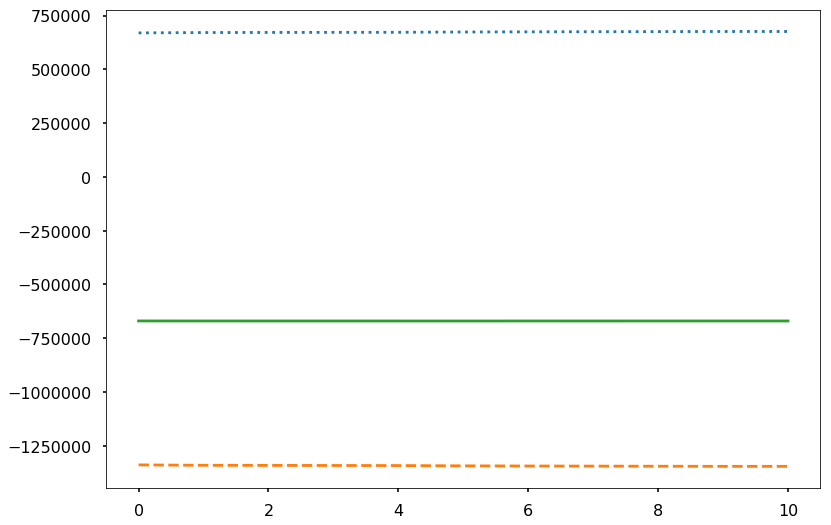

In [9]:
plot_energy('gpu_12-12_1000_100_100')

In [10]:
def plot_energy_diff(run_name, steps=None, get_every=1, ax=None, M_total=1e5):
    if ax is None:
        fig, ax = plt.subplots()
    K, U, E = get_energy(run_name, steps=steps, get_every=get_every, M_total=M_total)
    E0 = E[0]
    # ax.plot(K, ls=':', label=run_name)
    # ax.plot(U, ls='--', label=run_name)
    ax.plot((E-E0)/E0, ls='-', label=run_name)
    plt.ylabel('Relative total energy difference')
    plt.xlabel('Number of steps')
    plt.savefig('EnergyDiffCheck_'+run_name + '_split.png',dpi=300)
    return ax

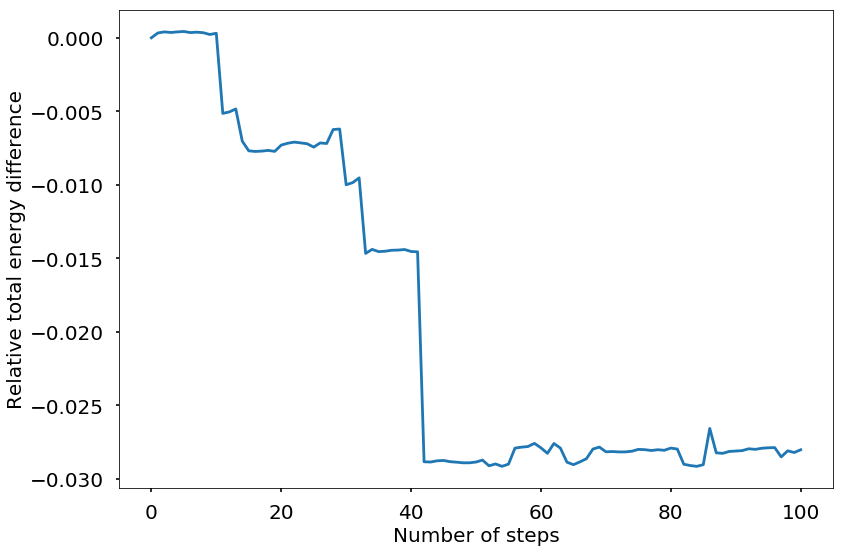

In [59]:
plot_energy_diff('serial_1000_1000_100', get_every=1)

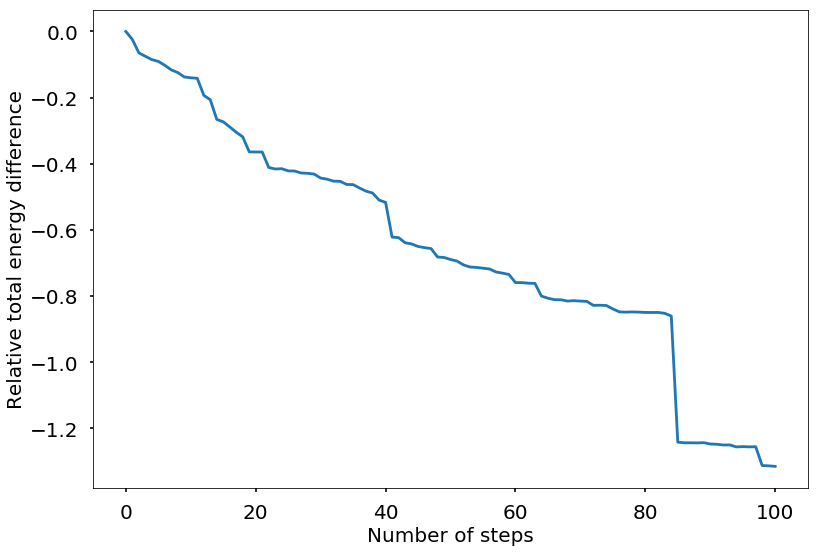

In [60]:
plot_energy_diff('serial_1000_1000_10', get_every=1)

In [56]:
def plot_energy_diff_comparison(run_name1, run_name2, steps=None, get_every=1, ax=None, M_total=1e5):
    if ax is None:
        fig, ax = plt.subplots(facecolor='w')
    K, U, E = get_energy(run_name1, steps=steps, get_every=get_every, M_total=M_total)
    E0 = E[0]
    xx = np.linspace(1,1000,np.size(E))
    ax.plot(xx,np.abs((E-E0)/E0), ls='-', label=r'$\Delta t = 0.01$ Myr')
    K, U, E = get_energy(run_name2, steps=steps, get_every=get_every, M_total=M_total)
    E0 = E[0]
    ax.plot(xx,np.abs((E-E0)/E0), ls='--', label=r'$\Delta t = 0.1$ Myr')
    ax.plot(xx, 0.03*np.ones(np.size(E)), ls=':')
    plt.text(850,0.038,r'$\frac{\Delta E}{E} \sim 3\%$',color='g',fontsize=20)
    plt.title('Energy conservation for runs with 1000 particles, 1 core')
    plt.yscale('log')
    plt.ylabel('Relative total energy difference')
    plt.xlabel('Number of steps')
    plt.xlim(0,1001)
    plt.legend(loc=4)
    plt.savefig('EnergyDiffCheck_'+run_name1+'_'+run_name2 + '_split.png',dpi=300)
    return ax

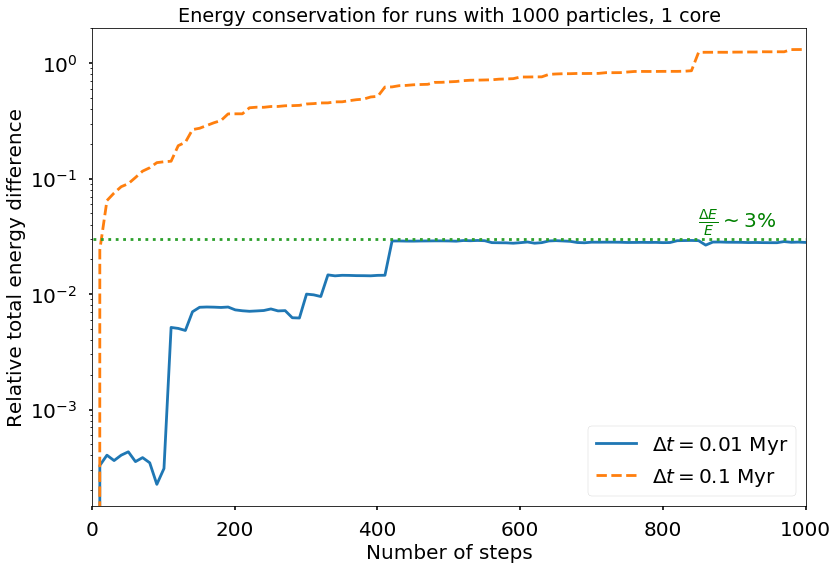

In [58]:
plot_energy_diff_comparison('serial_1000_1000_100', 'serial_1000_1000_10',get_every=1)